In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from PIL import Image

In [2]:
folder_path = "C:/Users/Bryan/USC/DSCI 552/final project"


In [3]:
categories = ["Gothic", "Modern", "Mughal", "Neoclassical", "Pagodas", "Pyramids"]

In [4]:
landmarks = []
images = []
targets = []
i = 0

for category in categories:
    subdir_path = os.path.join(folder_path, category)
    #print(subdir_path)
    
    # Iterate through each subfolder in the parent folder
    
    for landmark in os.listdir(subdir_path):
        landmarks.append(landmark)
        i += 1
        
    # Construct the full path to the subfolder
        next_path = os.path.join(subdir_path, landmark)
        
        # Iterate through each image file in the subfolder
        for filename in os.listdir(next_path):
            # Construct the full path to the image file
            image_path = os.path.join(next_path, filename)
            try: 
                # Read the image using OpenCV
                image = cv2.imread(image_path)
            
                #image = cv2.resize(image, (224, 224))

                # Convert the image to an array and normalize the pixel values
                #img_array = np.array(image) #/ 255.0
                images.append(image)
                targets.append(i)
                #break
            except Exception as e:
                print(f"Error processing file {image_path}: {e}")


            

In [5]:
#print(images)
print(len(targets))

420


In [6]:
print(landmarks)

['ChartresCathedral', 'CologneCathedral', 'MilanCathedral', 'Notre-DameCathedral', 'St.VitusCathedral', 'Cathedral of Brasília', 'CCTV Headquarters', 'Chrysler Building', 'eiffel', 'Hallgrímskirkja', 'Bibi Ka Maqbara', 'Jama Masjid', 'Taj Mahal', 'Tomb of Akbar', 'Tomb of I_timad-ud-Daulah', 'Academy of Athens', 'Buckingham Palace', 'Concertgebouw', 'Panthéon', 'Ripon Building', 'FogongTemplePagoda', 'GiantWildGoosePagoda', 'ShwedagonPagoda', 'ThienMuPagoda', 'TianningTemplePagoda', 'El Castillo, Chichen Itza', 'Louvre Pyramid', 'Pyramid of Djoser', 'Pyramid of Giza', 'Santa Cecilia Acatitlan Pyramid']


In [7]:
# central crop
# cross entropy outputs 30 classes; 
# images_resized = tf.keras.layers.Resizing(height=224, width=224,
#                                           crop_to_aspect_ratio=True)(images)

In [8]:
image_array = np.array(images)
for i in range(len(image_array)):
    if image_array[i] is not None:
        image_array[i] = tf.image.resize(image_array[i], [224, 224])
        image_array[i] = image_array[i] / 255.0


# train_generator = datagen.flow(
#     x=image_array,
#     batch_size=batch_size,
# )

C:\Users\Bryan\AppData\Local\Temp\ipykernel_15112\1599681575.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_array = np.array(images)


In [9]:
print(image_array[0].shape)

(224, 224, 3)


In [10]:
all_img = np.empty((len(image_array),) + image_array[0].shape)

for i in range(len(image_array)):
    all_img[i, :, :, :] = image_array[i]

In [11]:
all_img.shape

(420, 224, 224, 3)

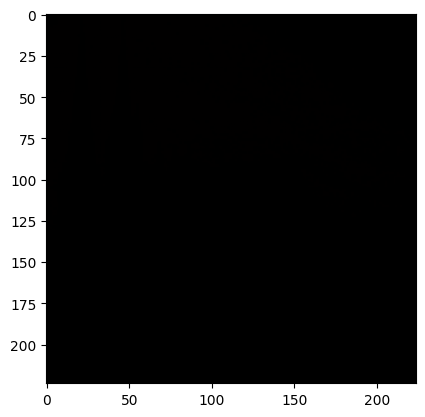

In [12]:
plt.imshow(np.clip(all_img[0], 0, 255) / 255.0)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    #rescale= 1./225,
    horizontal_flip=True,
    fill_mode='nearest')



In [14]:
# create a list of augmented images
aug_images = []
for image in all_img:
    # expand the dimensions of the image to match the expected input shape of the datagen
    image = np.expand_dims(image, axis=0)
    
    # generate 4 new images using the datagen
    for i in range(4):
        aug_iter = datagen.flow(image)
        aug_image = aug_iter.next()[0]
        aug_images.append(aug_image)

In [16]:
# Concatenate the original and augmented images
aug_images = np.array(aug_images)
all_images = np.concatenate([all_img, aug_images], axis=0)

# create a list of targets for the augmented images
aug_targets = []
for target in targets:
    aug_targets.extend([target] * 5)

# concatenate the original and augmented targets
labels = np.array(aug_targets)

In [17]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_images, labels, test_size=0.2, random_state=42)

In [18]:
with tf.device('/GPU:0'):
    eff_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    eff_x = tf.keras.layers.GlobalAveragePooling2D()(eff_model.output)
    eff_x = tf.keras.layers.Dropout(0.45)(eff_x)
    eff_x = tf.keras.layers.Flatten()(eff_x)
    eff_x = tf.keras.layers.Dense(units=512, activation='relu')(eff_x)
    eff_x = tf.keras.layers.Dropout(0.45)(eff_x)
    eff_x = tf.keras.layers.Dense(units=512, activation='relu')(eff_x)
    eff_x = tf.keras.layers.Dropout(0.45)(eff_x)
    eff_output = tf.keras.layers.Dense(units=len(targets), activation="softmax")(eff_x)

    model = tf.keras.Model(inputs=eff_model.input, outputs=eff_output)

    for layer in eff_model.layers[:-15]:
        layer.trainable = False

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                    metrics=["accuracy"])

In [19]:
# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10


KeyboardInterrupt: 